In [1]:
import pandas as pd
import numpy as np

import warnings

import ta
import smtplib
import time

import random

from sklearn.decomposition import PCA
from backtest_utils import *

## Building the proper dataset before PCA

In [2]:
complete_data = pd.read_csv('data/test.csv')

df, train, test = get_workable_data(complete_data)


df['Offensive'] = np.mean(df[['Value','Momentum','Carry']], axis=1)
df['Defensive'] = np.mean(df[['Quality','Size','Profitability']], axis=1)
df['Cash'] = 1000.0

n_stoch = 20
d_stoch = 10

df_benchmark = pd.DataFrame(df.Equi_weighted).copy()

df_prices = df.iloc[:,:6].copy().fillna(method='ffill') #(2)

for col in df_prices.columns:
    df_prices[col] = ta.momentum.stoch_signal(df_prices[col],df_prices[col],df_prices[col],\
                                              n=n_stoch, d_n=d_stoch, fillna=False)/100
    
df_macros = df.iloc[:,6:15].copy().fillna(method='ffill') #(2)


df_acp = pd.concat([df_prices, df_macros], axis=1).dropna()
df_acp = (df_acp - df_acp.mean())/df_acp.std()


In [3]:
import matplotlib.pyplot as plt
df_acp.plot(figsize=(15,10))
plt.show()

<Figure size 1500x1000 with 1 Axes>

### Static PCA

In [4]:
n_comp = 10

pca = PCA(n_components=n_comp)
principalComponents = pca.fit_transform(df_acp)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal compnent '+str(i) for i in range(n_comp)], index = df_acp.index)

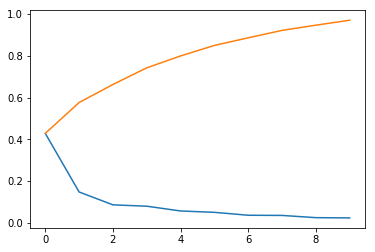

,0
0,0.428580
1,0.576392
2,0.662666
3,0.742479
4,0.799399
5,0.849833
6,0.886248
7,0.921825
8,0.946739
9,0.970402


In [5]:
plt.plot(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
pd.DataFrame(np.cumsum(pca.explained_variance_ratio_).T)

In [6]:
n_comp = 4

pca = PCA(n_components=n_comp)
principalComponents = pca.fit_transform(df_acp)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal compnent '+str(i) for i in range(n_comp)], index = df_acp.index)

### Rolling PCA

In [7]:
rolling_pca_df = principalDf.copy()

for i in range(n_comp, len(rolling_pca_df.index)):
    dff = pd.DataFrame(PCA(n_components=n_comp).fit_transform(df_acp.loc[df_acp.index[:i],:]), index = principalDf.index[:i], \
            columns=principalDf.columns)
    rolling_pca_df.loc[dff.index[-1]] = dff.iloc[-1]

### How stable is the rolling PCA and how fast do both PCAs converge to each other ?

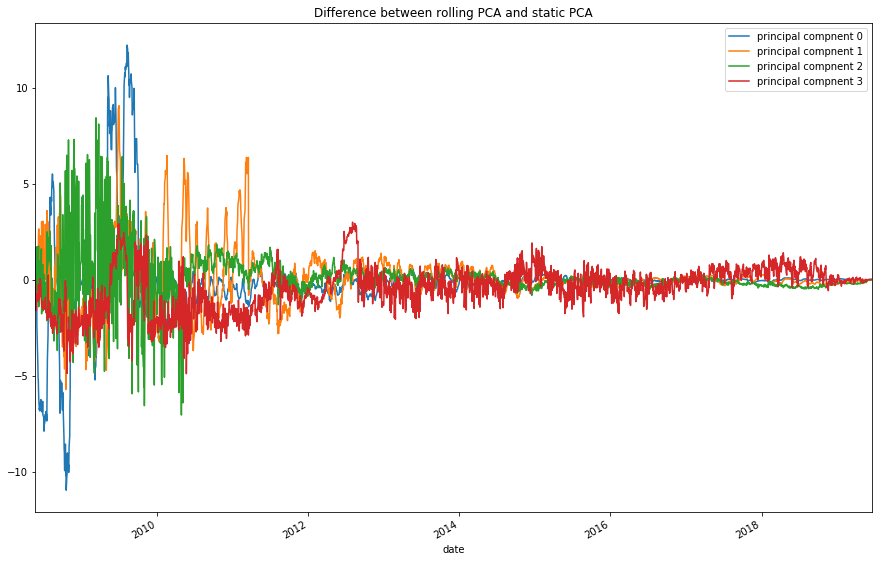

In [8]:
import matplotlib.pyplot as plt
(rolling_pca_df-principalDf).plot(figsize=(15,10))
# plt.figure(figsize=(15,10))
# plt.plot(rolling_pca_df-principalDf)
plt.title("Difference between rolling PCA and static PCA")
plt.show()

### What are the factors made of ?

In [9]:
df_comp = pd.DataFrame(pca.components_.T, columns=['principal compnent '+str(i) for i in range(n_comp)],\
            index = df_acp.columns)
df_comp

,principal compnent 0,principal compnent 1,principal compnent 2,principal compnent 3
Value,-0.359639,0.171991,0.037444,0.064609
Quality,-0.336150,0.164176,0.076615,-0.009143
Carry,-0.352241,0.183547,0.034768,0.036957
Profitability,-0.363813,0.177132,0.064800,0.019419
Size,-0.364510,0.189202,0.068635,0.052574
Momentum,-0.362229,0.176476,0.041063,-0.008912
UX2-UX5,0.204192,0.319792,0.044893,0.311662
UX5-UX8,0.156259,0.338210,0.120954,0.123885
CSI BARC-BASPCAAA,-0.072245,-0.198067,0.391977,-0.533255
SGEPVBE-SGEPLBE,-0.074405,-0.235392,-0.157552,0.689475


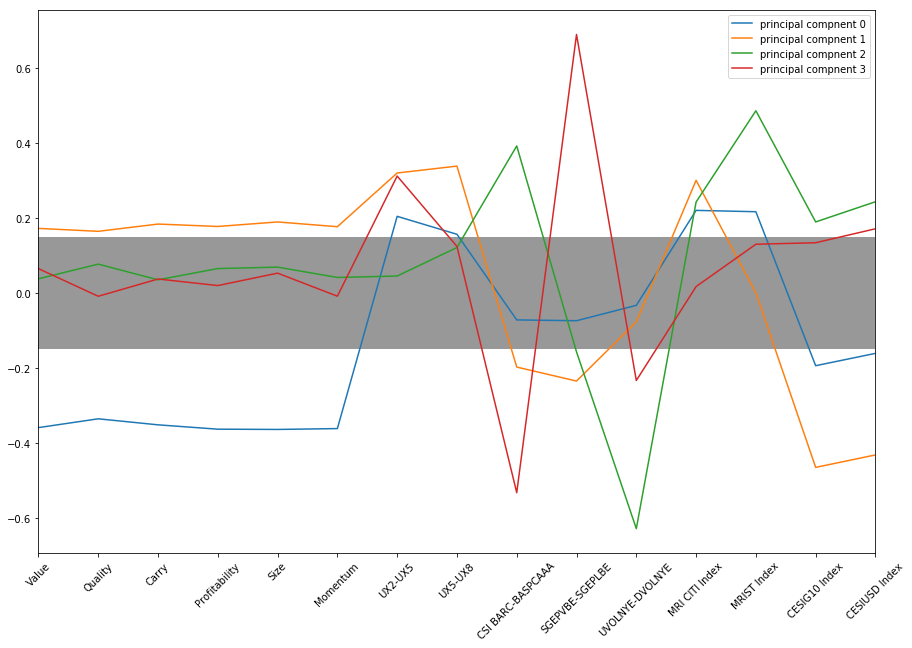

In [10]:
# plt.figure(figsize=(15,10))
df_comp.plot(figsize=(15,10))
plt.xticks(range(len(df_comp.index)), df_comp.index)
plt.xticks(rotation=45)
plt.axhspan(-0.15, 0.15, facecolor='0.2', alpha=0.5)
plt.show()

In [11]:
rolling_pca_df = rolling_pca_df.iloc[3:,:]

In [12]:
# rolling_pca_df.to_csv('data/rolling_pca.csv')